In [1]:
import matplotlib.pyplot as plt
import numpy as np

import netgen
from firedrake import *
from netgen.occ import *
from ngsPETSc import NetgenHierarchy

/root/firedrake/lib/python3.10/site-packages/ngsPETSc/eps.py:10: UserWarning: Import Warning: it was not possible to import SLEPc
  warnings.warn("Import Warning: it was not possible to import SLEPc")


/root/firedrake/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


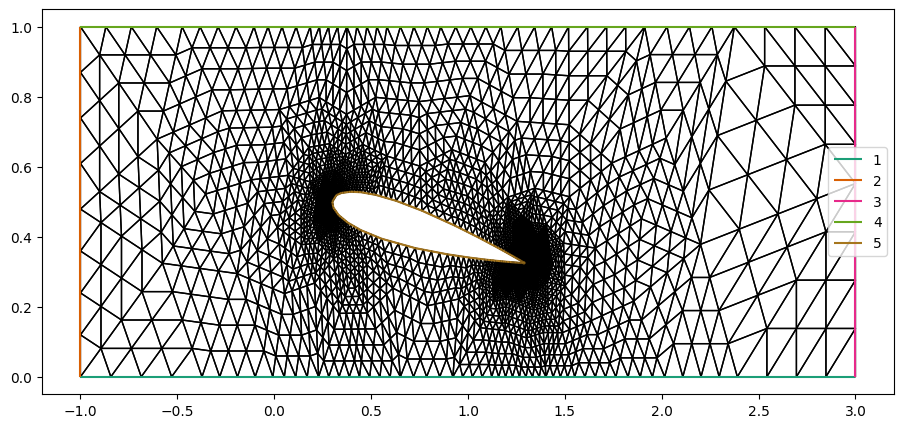

In [2]:
t = 0.12 # specify NACA00xx type

N_x = 100
x = np.linspace(0,1.0089,N_x)

def naca00xx(x,t):
  y = 5*t*(0.2969*(x**0.5) - 0.1260*x - 0.3516*(x**2) + 0.2843*(x**3) - 0.1015*(x**4))

  return np.concatenate((x,np.flip(x)),axis=None), np.concatenate((y,np.flip(-y)),axis=None)

x, y = naca00xx(x,t)

pnts = [Pnt(x[i], y[i], 0) for i in range(len(x))]

spline = SplineApproximation(pnts)
aerofoil = Face(Wire(spline)).Move((0.3,0.5,0)).Rotate(Axis((0.3,0.5,0), Z), -10)
rect = WorkPlane(Axes((-1, 0, 0), n=Z, h=X)).Rectangle(4, 1).Face()
domain = rect - aerofoil

domain.edges.name="wing"
domain.edges.Min(Y).name="bottom"
domain.edges.Max(Y).name="top"
domain.edges.Min(X).name="inlet"
domain.edges.Max(X).name="outlet"
geo = OCCGeometry(domain, dim=2)

ngmesh = geo.GenerateMesh(maxh=1)
ngsolve_mesh = Mesh(ngmesh)

mh = MeshHierarchy(ngsolve_mesh, 2)
mesh = mh[-1]

fig = plt.figure(figsize=(11,5))
ax1 = fig.add_subplot(1, 1, 1)
triplot(mesh,axes=ax1)
plt.gca().legend()
plt.show()

In [5]:
def solve_navierstokes(mesh,sp,nu):

  n = FacetNormal(mesh)
  (x, y) = SpatialCoordinate(mesh)

  # Define Taylor--Hood function space W
  V = VectorFunctionSpace(mesh, "CG", 2)
  Q = FunctionSpace(mesh, "CG", 1)
  W = MixedFunctionSpace([V, Q])

  bcs = DirichletBC(W.sub(0), Constant((0,0)), (1,4,5))

  p0=10/13-x/13 #1atleft,0atright

  # Define Function and TestFunction(s)
  w = Function(W, name="Solution")
  (u, p) = split(w)
  (v, q) = split(TestFunction(W))

  # Define variational form
  F = (
        inner(2*nu*sym(grad(u)), sym(grad(v)))*dx
        - div(u)*q*dx
        - div(v)*p*dx
        + p0*dot(v,n)*ds
        - inner(outer(u, u), sym(grad(v)))*dx
        + inner(dot(outer(u, u), n), v)*ds
        )

  # Solve problem
  #w.interpolate(Constant(1,1))
  solve(F == 0, w, bcs, solver_parameters=sp)

  # Save solutions
  (u_, p_) = w.subfunctions
  u_.rename("Velocity")
  p_.rename("Pressure")

  return u_, p_

  0 SNES Function norm 2.615338182364e-01
    Residual norms for firedrake_0_ solve.
    0 KSP Residual norm 4.308239917389e+01
    1 KSP Residual norm 2.480682439938e-13
  1 SNES Function norm 1.345947104179e-05
    Residual norms for firedrake_0_ solve.
    0 KSP Residual norm 6.716988954280e-03
    1 KSP Residual norm 2.312681618572e-16
  2 SNES Function norm 2.032597071295e-11
Nonlinear firedrake_0_ solve converged due to CONVERGED_FNORM_ABS iterations 2


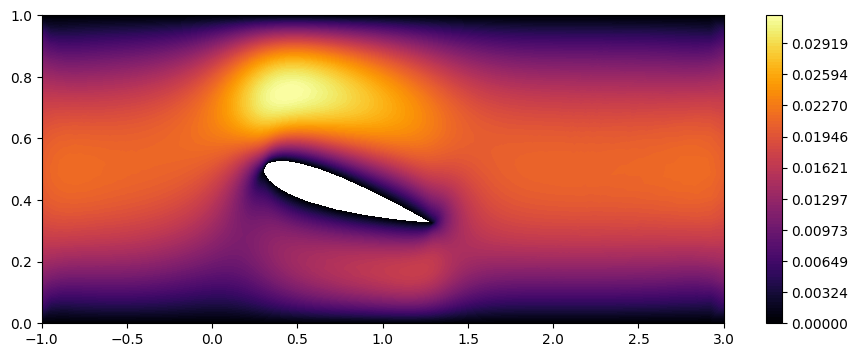

In [6]:
sp = {
      "ksp_type": "cg", # use conjugate gradients
      "ksp_monitor": None, # print info about iteration
      "ksp_rtol": 1.0e-10, # residual relative tolerance
      "snes_monitor": None, # monitor convergence info
      "snes_converged_reason": None, # say why it finished
      "snes_atol": 1e-8, # termination criterion
      "snes_linesearch_type": "l2", # use a line search
      #"pc_type": "mg", # use geometric multigrid
      }

nu = Constant(0.2)

u_alt, p_alt = solve_navierstokes(mesh,sp,nu)

fig = plt.figure(figsize=(11,4))

ax1 = fig.add_subplot(1, 1, 1)
levels = np.linspace(0, u_alt.dat.data.max(), 100)
contours = tricontourf(u_alt, levels=levels, axes=ax1, cmap="inferno")
fig.colorbar(contours, ax=ax1)

In [3]:
def solve_preconditioned_ns(mesh,sp,Re,gamma):

  n = FacetNormal(mesh)
  (x, y) = SpatialCoordinate(mesh)

  # Define Scott--Vogelius function space W
  V = VectorFunctionSpace(mesh, "CG", 4)
  Q = FunctionSpace(mesh, "DG", 3)
  W = MixedFunctionSpace([V, Q])

  bcs = DirichletBC(W.sub(0), Constant((0,0)), (1,4,5))

  w = Function(W, name="Solution")
  (u, p) = split(w)
  (v, q) = split(TestFunction(W))

  p0 = 10/13 - x/13 #1atleft,0atright
  #f = Constant((0,-9.81))

  # Define Lagrangian
  L = (
  0.5 * inner(2/Re * sym(grad(u)), sym(grad(u)))*dx
      + inner(dot(u,grad(u)),u)*dx
      -       inner(p, div(u))*dx
      +       p0 * inner(n, u)*ds
      #-       inner(f,u)*dx
      + 0.5 * gamma * inner(div(u), div(u))*dx
      )

  # Optimality conditions
  F = derivative(L, w)

  # Solve problem
  solve(F == 0, w, bcs, solver_parameters=sp) # Monitor incompressibility
  print(f"||div u||: {norm(div(u), 'L2'):.2e}")

  # Save solutions
  (u_, p_) = w.subfunctions
  u_.rename("Velocity")
  p_.rename("Pressure")
  #File("output/stokes.pvd").write(u_, p_)

  return u_, p_

In [5]:
class DGMassInv(PCBase):
  def initialize(self, pc):
    _, P = pc.getOperators()
    appctx = self.get_appctx(pc)
    V = dmhooks.get_function_space(pc.getDM())

    # get function spaces
    u = TrialFunction(V)
    v = TestFunction(V)
    massinv = assemble(Tensor(inner(u, v)*dx).inv)
    self.massinv = massinv.petscmat

  def update(self, pc):
    pass

  def apply(self, pc, x, y):
    self.massinv.mult(x, y)
    scaling = 1/float(Re) + float(gamma)
    y.scale(-scaling)

  def applyTranspose(self, pc, x, y):
    raise NotImplementedError("Sorry!")

  0 SNES Function norm 1.891760872766e-01
    Residual norms for firedrake_1_ solve.
    0 KSP unpreconditioned resid norm 1.891760872766e-01 true resid norm 1.891760872766e-01 ||r(i)||/||b|| 1.000000000000e+00
    1 KSP unpreconditioned resid norm 5.496515134242e-06 true resid norm 5.496515042789e-06 ||r(i)||/||b|| 2.905502022966e-05
    2 KSP unpreconditioned resid norm 4.504995747224e-08 true resid norm 4.504995903657e-08 ||r(i)||/||b|| 2.381377037929e-07
    3 KSP unpreconditioned resid norm 5.248137958226e-10 true resid norm 5.270953354619e-10 ||r(i)||/||b|| 2.786268301930e-09
  Linear firedrake_1_ solve converged due to CONVERGED_ATOL iterations 3
  1 SNES Function norm 3.167943280002e-04
    Residual norms for firedrake_1_ solve.
    0 KSP unpreconditioned resid norm 3.167943280002e-04 true resid norm 3.167943280002e-04 ||r(i)||/||b|| 1.000000000000e+00
    1 KSP unpreconditioned resid norm 3.435425248181e-07 true resid norm 3.435425219648e-07 ||r(i)||/||b|| 1.084433942152e-03
 

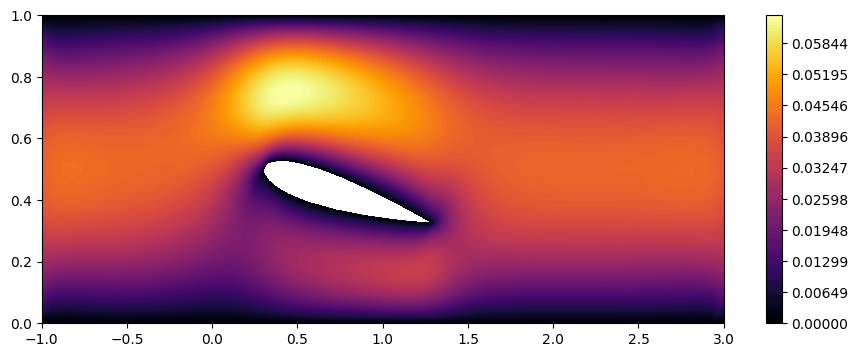

In [6]:
sp = {
'mat_type': 'nest',
'snes_monitor': None,
'snes_converged_reason': None,
'snes_max_it': 20,
'snes_atol': 1e-8,
'snes_rtol': 1e-12,
'snes_stol': 1e-06,
'ksp_type': 'fgmres',
'ksp_converged_reason': None, 'ksp_monitor_true_residual': None,
'ksp_max_it': 500,
'ksp_atol': 1e-08,
'ksp_rtol': 1e-10,
'pc_type': 'fieldsplit',
'pc_fieldsplit_type': 'schur', 'pc_fieldsplit_schur_factorization_type': 'full',

'fieldsplit_0': {'ksp_convergence_test': 'skip',
                 'ksp_max_it': 1,
'ksp_norm_type': 'unpreconditioned', 'ksp_richardson_self_scale': False, 'ksp_type': 'richardson',
'pc_type': 'mg',
                 'pc_mg_type': 'full',
                 'mg_coarse_assembled_pc_type': 'lu',
                 'mg_coarse_assembled_pc_factor_mat_solver_type': 'mumps',
                 'mg_coarse_pc_python_type': 'firedrake.AssembledPC',
                 'mg_coarse_pc_type': 'python',
                 'mg_levels': {'ksp_convergence_test': 'skip',
                               'ksp_max_it': 5,
                               'ksp_type': 'fgmres',
                               'pc_python_type': 'firedrake.ASMStarPC',
                               'pc_type': 'python'},
                },
'fieldsplit_1': {'ksp_type': 'preonly',
                 'pc_python_type': __name__ + '.DGMassInv',
                 'pc_type': 'python'},
}

# Define Reynolds number and bcs
Re = Constant(10)
gamma = Constant(10000)

u, p = solve_preconditioned_ns(mesh,sp,Re,gamma)

fig = plt.figure(figsize=(11,4))

ax1 = fig.add_subplot(1, 1, 1)
levels = np.linspace(0, u.dat.data.max(), 100)
contours = tricontourf(u, levels=levels, axes=ax1, cmap="inferno")
fig.colorbar(contours, ax=ax1)